# Chapter 6

# K-Means Clustering

## 6.1 A New Marketing Plan for a Wholesale Distributor

The first step we take a tackling this problem is by taking a look at the dataset we have via a random sample

In [1]:
import pandas as pd

data = pd.read_csv("../datasets/wholesale.csv")
data.sample(10, random_state=42)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
265,1,1,5909,23527,13699,10155,830,3636
78,1,3,10766,1175,2067,2096,301,167
347,2,3,27380,7184,12311,2809,4621,1022
255,1,1,31614,489,1495,3242,111,615
327,1,2,542,899,1664,414,88,522
291,1,3,6022,3354,3261,2507,212,686
184,1,3,327,918,4710,74,334,11
82,2,3,10362,9232,11009,737,3537,2342
438,1,3,10290,1981,2232,1038,168,2125
405,1,3,6884,1046,1167,2069,593,378


---
Before we can apply scikit-learn's `Kmeans` module on our customers data, we first need to extract the relevant data to the problem, which are all the continous features that represent the amount of money spent on different products.

In [2]:
X = data.loc[:, "Fresh":"Delicassen"]

---
Prior to using the data to fit our k-means model, it'd be a good idea to look at their descriptive statistics and see what they tell us about the data and whether if there's a problem that we need to take into consideration. We can quickly do that with the `describe` method of pandas `DataFrame`.

In [3]:
X.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


---
### 6.1.2 All Features Shall be Equal
As we can see from the descriptive statistics above, the features have very different standard deviations (hence, variances). This can cause problems with models that use Euclidean distnaces such as our Kmeans method. We can see this problem by looking at how one point form our data is assigned to one of two randomly chosen centroids.

In [4]:
X.loc[[110, 124, 240]]  # just to display the points

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
110,11818,1648,1694,2276,169,1647
124,36050,1642,2961,4787,500,1621
240,22096,3575,7041,11422,343,2564


In [6]:
import numpy as np

bad_X_df = X.loc[[110, 124, 240]]
bad_X = bad_X_df.as_matrix()  # underlying ndarrays

def d(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

print("Distance to 1st centroid: {:.2f}".format(d(bad_X[0], bad_X[1])))
print("Distance to 2nd centroid: {:.2f}".format(d(bad_X[0], bad_X[2])))

Distance to 1st centroid: 24396.94
Distance to 2nd centroid: 14915.14


/home/mostafa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [7]:
(bad_X_df - bad_X_df.loc[110]) ** 2

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
110,0,0,0,0,0,0
124,587189824,36,1605289,6305121,109561,676
240,105637284,3713329,28590409,83649316,30276,840889


---
Intutively, one would think that the closest centroid to the point is the first one, but the distance calculations say otherwise. It seems that the difference in higher variance components outweighs the small differences in the lesser variance ones. We can solve this by scaling the data into a common scale using `StandardScaler`

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaled_bad_X = scaler.transform(bad_X)

print("[Scaled] Distance to 1st centroid: {:.2f}".format(d(scaled_bad_X[0], scaled_bad_X[1])))
print("[Scaled] Distance to 2nd centroid: {:.2f}".format(d(scaled_bad_X[0], scaled_bad_X[2])))

[Scaled] Distance to 1st centroid: 1.99
[Scaled] Distance to 2nd centroid: 2.17


---
### 6.1.3 Applying K-means with scikit-learn
Now that we have scaled our data and got rid of the different variance problem, we're now ready to apply the k-means method on our data using scikit-learn. We set the number of clusters to be 5 for now

In [9]:
from sklearn.cluster import KMeans

scaled_X = scaler.transform(X)

model = KMeans(n_clusters=5, n_init=20)
model.fit(scaled_X)

print("Minimum Inertia: {:.2f}".format(model.inertia_))

Minimum Inertia: 1058.77


While the important information about clustering are available in our `model` object, these information is just numbers. It'd nice to be able to see a visual depiction of our clustering result. The problem in producing a visual representation of the clustreing is that our data live in a 6-dimensional space (the number of features in our dataset), and we can't visualize a space with such high dimensionality. To solve this, we'll rely on dimesnionality reduction which attemps to compress a large set of features into a smaller representative set (we talked about that briefly back in chapter 4). We're going to use _Principal Component Analysis_ (PCA) to compress our 6 features into 2.

In [10]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
reduced_X = reducer.fit_transform(scaled_X)

print("Reduced Shape: {}, vs. Original Shape: {}".format(reduced_X.shape, scaled_X.shape))

Reduced Shape: (440, 2), vs. Original Shape: (440, 6)


We can see that PCA was indeed able to transform our data array from a shape of (440, 6) to a shape of (440, 2), we now can use these two compressed features (or principal components) to visualize our data on a 2D grid. We'll use `matplotlib.pyplot`'s `scatter` method to visualize our points in the 2D space. The `scatter` method takes two paremeters which represents the points coordinates on the x and y axes.

Text(0, 0.5, 'Second Principal Component')

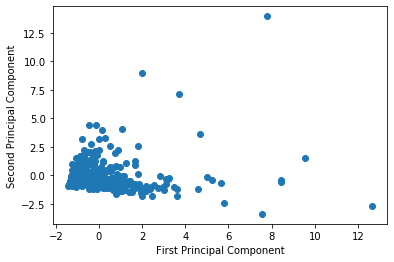

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(reduced_X[:, 0], reduced_X[:, 1])

# these change the labels of the x and y axes
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

To make the scatters visible, we can pass a third parameter to `scatter` called `c` that defines the color of each point scattred in the 2D space. To group each cluster's point with the same color, we pass `model.labels_` as the value for that parameter. 

Text(0, 0.5, 'Second Principal Component')

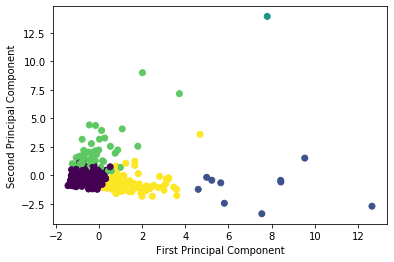

In [12]:
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=model.labels_)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

We can even scatter plot the centroids as well using a different point style of [marker](https://matplotlib.org/api/markers_api.html#module-matplotlib.markers), and specifying the edgecolors and s (for size) for enhanced visibility.

Text(0, 0.5, 'Second Principal Component')

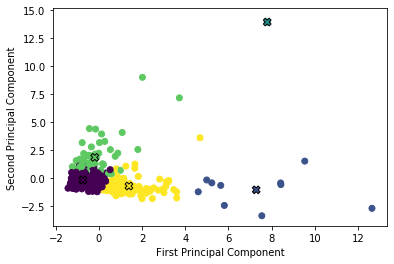

In [13]:
reduced_centroids = reducer.transform(model.cluster_centers_)

plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=model.labels_)
plt.scatter(
    reduced_centroids[:, 0], reduced_centroids[:, 1], 
    marker='X', s=60, c=np.arange(0, 5), edgecolors='black'
)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

Using PCA together with matplotlib capabilities, we now have a pretty satisfying visualization of the clustering we computed, now it's time to analyze it and see what it tells us about the customers. But, wait a second, we have set k to be 5 in our clustering, but that's a hyperparameter. One might think that we can use the value of inertia to choose the value of k, such the that the best value of k is the one with the lowest inertia possible, and since we don't have any labels we won't be able to do any training/validation/test split as there's nothing to validate/test against.

In [14]:
def find_best_k(max_k):
    lowest_inertia, best_k = np.inf, None
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k)
        model.fit(scaled_X)
        if model.inertia_ < lowest_inertia:
            lowest_inertia = model.inertia_
            best_k = k
            
    return best_k

print("Best k is: {}".format(find_best_k(10)))

Best k is: 10


inertia keeps decreasing as we increase the number of cluster till we reach the maximum number of cluster we set in the call to find_best_k, which is 10. Maybe if we increased that limit to, say 30, the search would be able to find the lowest inertia in between?

In [15]:
print("Best k is: {}".format(find_best_k(30)))

Best k is: 30


It seems that our search found the maximum value of k as the best value. Actually, if we thought about it more carefully, the inertia is not the metric to use to find the best number of clusters. When we increase the number of clusters, by increasing the centroids we're also increasing the possibilities of a point to find a centroid close to it, which decreases the inertia. This pattern continues up until the point where set the number of clusters to be the same as the number of points in the data. In that case, the centroid of a cluster will be identical with the point that belongs to it, which brings down the inertia to 0, the lowest possible value! We can verify that by actually running that scenario and plot the relation between the number of clusters using matplotlib's plot method, which works exactly like the scatter method with the difference that it connects the points plotted with a line.

Text(0, 0.5, 'Inertia')

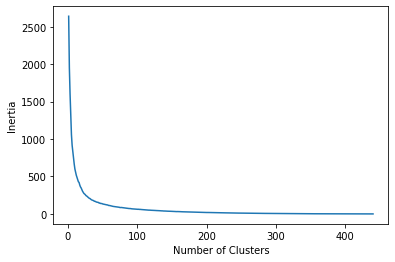

In [16]:
data_size, _ = scaled_X.shape

inertias = []
for k in range(1, data_size + 1):
    model = KMeans(n_clusters=k)
    model.fit(scaled_X)
    inertias.append(model.inertia_)
    
plt.plot(np.arange(1, data_size + 1), inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

## 6.2 Tuning the Value of k with Silhoutte Score
### 6.2.1 Creating Marketing Plans Against the Detected Customers Segments

However, we can use `silhoutte_score` to find the best value of k. Silhoutte scores capture how coherent each cluster is and how seprabale each cluster is from the other. This would be a better repesentation of clustering quality that does not have the same problem as the inertia.

Best k is: 2, with Silhouette Score: 0.59


Text(0, 0.5, 'Silhouette Score')

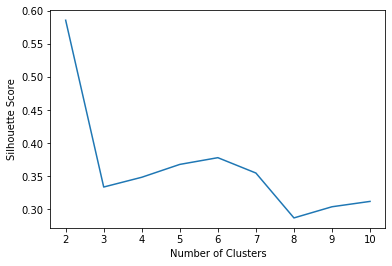

In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_X)
    silhouette_scores.append(silhouette_score(scaled_X, model.labels_))
    
best_k = np.argmax(silhouette_scores) + 2
best_silhouette = np.max(silhouette_scores)
print("Best k is: {}, with Silhouette Score: {:.2f}".format(best_k, best_silhouette))

plt.plot(np.arange(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

Our silhouette scores analysis shows that the best clustering happens when the number of clusters is two, which suggests that there are likely two natural groups of customers within our data set. We can now start inspecting the characteristics  of each cluster in order to devise an appropriate marketing plan targeting each of them. We start by retrieving the two clusters' points form the original data frame using their label form our best k-means model.

In [23]:
best_model = KMeans(n_clusters=2, random_state=42)
best_model.fit(scaled_X)

first_cluster_mask = best_model.labels_ == 0
first_cluster = data[first_cluster_mask]
second_cluster = data[~first_cluster_mask]

Let's look at the representative behavior of the second cluster by checking the value of its mean.

In [25]:
second_cluster.mean()

Channel                 1.948718
Region                  2.435897
Fresh               12078.923077
Milk                21367.948718
Grocery             29886.384615
Frozen               3199.641026
Detergents_Paper    14134.974359
Delicassen           3781.769231
dtype: float64

We can see that the second cluster, which represents retails stores, purchases most of the products with more than 10k on average. Form this, we can draw a possible marketing strategy targeted at retail stores by offering a discount on a whole package purchase that includes all the types of products our distributor can offer. Such an offer can be tempting for the retail stores; because they tend to purchase all their supplies at large quantities and they would appreciate a discount on the whole deal. On the other hand, would such an offer be tempting for hotels, cafes and restaurants as well? We can answer that question by inspecting the representative purchasing behavior of the first cluster.  

In [26]:
first_cluster.mean()

Channel                 1.261845
Region                  2.553616
Fresh               11992.650873
Milk                 4281.812968
Grocery              5817.937656
Frozen               3059.511222
Detergents_Paper     1787.014963
Delicassen           1305.371571
dtype: float64

The first cluster, however, seems to dedicate its money more on Fresh ingredients, which means that a discount offer on the whole package is not likely to be tempting for them. So to target this cluster of customers, it may be tempting to offer a discount on the Fresh purchases to restaurants, cafes and hotels

---
<font color='darkred'>
<h4> Exercise 6.1 </h4>
<br/>
To further appreciate the value of feature scaling, repeat the script where we tuned the value of k using silhouette score but this time with the unscaled version of the data.  Notice what happens to the best silhouette score due to that change.
</font>

In [ ]:
# Your solution goes here

## 6.3 Limitations of K-means

Whether a clustering is correct or not is a tough question; we do not have any true labels to compare against and see if the predicted results are correct or not. And metrics like the silhouette score doesn't guarantee the correctness of clustering, it just ensures that the clustering we get is well behaved in terms of cohesion and separation, which makes more likely to be correct, but that's not guaranteed. To see that we can make use of scikit-learn's synthetic datasets generator in order to generate multiple datasets with pre-known clusters and compare K-means results to it, hence revealing the limitations of k-means method.

Blobs
    - True clusters std ratio: (1.08, 1.02)
    - K-means clusters std ratio: (1.08, 1.02)
Elongated
    - True clusters std ratio: (4.89, 4.66)
    - K-means clusters std ratio: (2.30, 2.14)
Moons
    - True clusters std ratio: (2.28, 2.27)
    - K-means clusters std ratio: (1.37, 1.36)
Concentric Circles
    - True clusters std ratio: (1.00, 1.01)
    - K-means clusters std ratio: (1.63, 1.63)


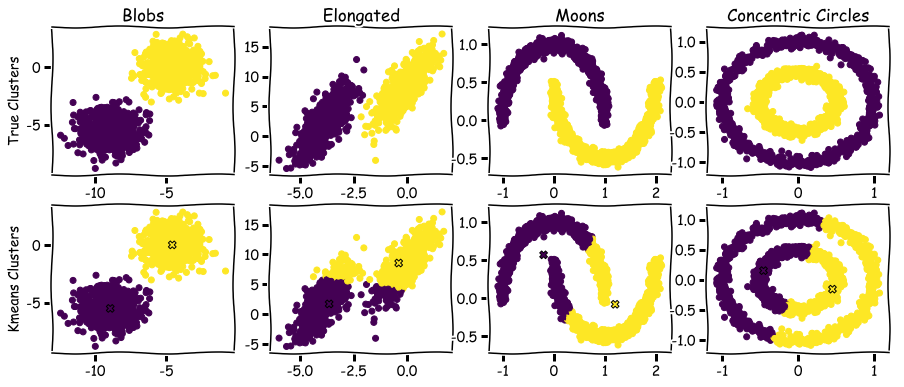

In [20]:
from sklearn.datasets import make_blobs, make_moons, make_circles

plt.xkcd()
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for i, data_shape in enumerate([
    'Blobs', 'Elongated', 'Moons', 'Concentric Circles'
]):

    original_axis = axes[0, i]
    kmeans_axis = axes[1, i]
    
    # labels each row in the plot with what it represents
    if i == 0:
        original_axis.set_ylabel("True Clusters")
        kmeans_axis.set_ylabel("Kmeans Clusters")
    
    # generate the dataset using sklearn.dataset methods given the shape
    if data_shape == 'Blobs':
        X, y = make_blobs(n_samples=1500, centers=2, random_state=170)
    elif data_shape == 'Elongated':
        X, y = make_blobs(n_samples=1500, centers=2, random_state=170)
        transformation = np.array(
            [[ 0.03412646, -1.76449409],
             [ 0.63937541,  2.45397584]]
        )
        
        # this transforms the circular blobs into ellipsoidal ones 
        X = np.dot(X, transformation)
        
    elif data_shape == 'Moons':
        X, y = make_moons(n_samples=1500, random_state=170, noise=0.05)
    else:
        X, y = make_circles(
            n_samples=1500, random_state=170, factor=0.5, noise=0.05)
    
    # scatter plot the data with their true labels
    original_axis.scatter(X[:, 0], X[:, 1], c=y)
    original_axis.set_title(data_shape)
    
    # fit a kmeans model to the data
    kmeans_model = KMeans(n_clusters=2)
    kmeans_model.fit(X)
    centroids = kmeans_model.cluster_centers_
    predicted = kmeans_model.labels_
    
    # scatter plot the kmeans clustering along with the centroids
    kmeans_axis.scatter(X[:, 0], X[:, 1], c=predicted)
    kmeans_axis.scatter(
        centroids[:, 0], centroids[:, 1], c=[0, 1], marker='X', s=60, edgecolors='black'
    )
    
    # calculate and print the standard deviation ratios in both cluster
    # in both settings, the original and the fitted kmeans
    print(data_shape)
    print("=================")
    for clustering in ["True", "K-means"]:
        std_ratios = []
        for label in [0, 1]:
            labels = y if clustering == "True" else predicted
            cluster = X[(labels == label)]
            stds = np.std(cluster, axis=0)
            std_ratios.append(np.max(stds) / np.min(stds))

        print("    - {} clusters std ratio: ({:.2f}, {:.2f})".format(clustering, *std_ratios))   

The above experiment is showing us a key limitation of the k-means algorithm; which is that it tends to craete circular clusters.

<font color='darkred'>
<h4>Exercise 6.2</h4>
<br/>
Using what you learned from our last experiments code, recreate figure 6-17 and check that this is indeed the clustering with the highest silhouette score. Use random_state=42 to get consistent results.
</font>

In [ ]:
# Your solution goes here